# Introduction: Gammapy behind the scenes

**Objective**: Give an overview of Gammapy while exposing how things work under the hood


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True


## The Map Abstraction
Every data component (counts, exposure, background, etc.) is stored as a Map — a structured array with the following structure:

$$
\texttt{Map}
=
\begin{cases}
  \texttt{.geom} =
  \left\{
  \begin{array}{ll}
    \texttt{Spatial geometry:} & \texttt{WCS / Region / HEALPix}\\
    \texttt{Axes:} & \texttt{[energy, time, ...]}\\
    \texttt{Frame:} & \texttt{galactic / icrs}
  \end{array}
  \right. \\[10pt]
  \texttt{.data} \rightarrow \text{N-dimensional array } \\[4pt]
  \texttt{.unit} \rightarrow \text{Physical unit} \\[4pt]
  \texttt{.meta} \rightarrow \text{dict (header info)}
\end{cases}
$$

In [69]:
from gammapy.maps import WcsGeom, RegionGeom, Map, WcsNDMap

wcs_geom = WcsGeom.create(
    skydir=SkyCoord.from_name("PKS 2155-304"),
    binsz=0.04,
    width=(10,4),
    proj="TAN",
    frame="icrs"
)

print(wcs_geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (np.int64(250), np.int64(100))
	ndim       : 2
	frame      : icrs
	projection : TAN
	center     : 329.7 deg, -30.2 deg
	width      : 10.0 deg x 4.0 deg
	wcs ref    : 329.7 deg, -30.2 deg



<WCSAxes: >

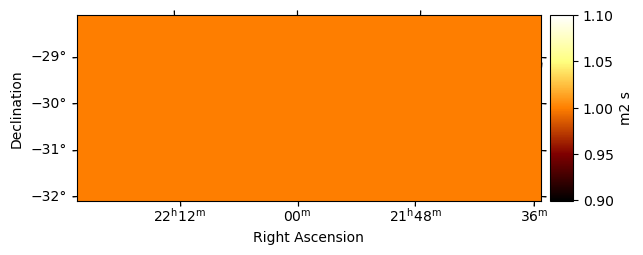

In [72]:
exposure = Map.from_geom(wcs_geom, unit="m2s", data=np.ones((100,250)))
exposure.plot(add_cbar=True)

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat']
	shape      : (1, 1)
	ndim       : 2
	frame      : fk5
	center     : 329.7 deg, -30.2 deg



<WCSAxes: >

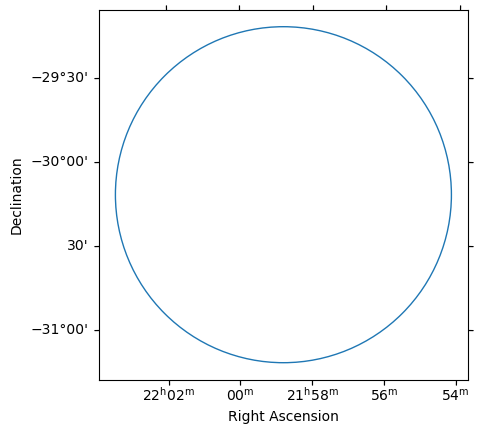

In [4]:
region_geom = RegionGeom.create("fk5;circle(329.7, -30.2, 1.0)")
print(region_geom)

region_geom.plot_region()

It is important to note that `SkyRegions` objects are defined w.r.t. a given WCS coordinate system. They are not real spherical regions. 
Hence, Gammapy creates an internal `WcsGeom` defined around the region center using the `'TAN'` projection.

In [5]:
print(region_geom.wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 329.69999999999993 -30.20000000000001 
CRPIX : 11.5 11.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.1 0.1 
NAXIS : 22  22


Let's see a more complex example, where the wcs has a direct impact on the region orientation.

<WCSAxes: >

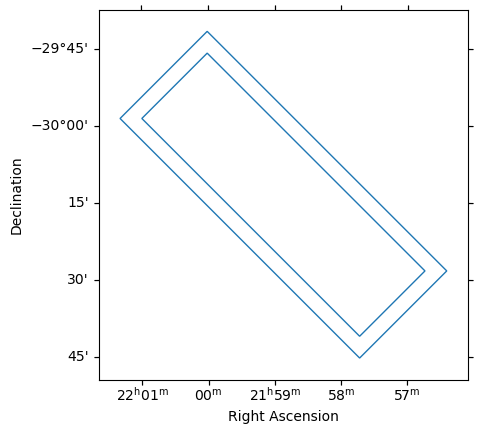

In [6]:
from regions import RectangleAnnulusSkyRegion, CircleSkyRegion

complex_region = RectangleAnnulusSkyRegion(
    center=SkyCoord.from_name("PKS 2155-304"),
    inner_width=0.3*u.deg,
    outer_width=0.4*u.deg,
    inner_height=1*u.deg,
    outer_height=1.1*u.deg,
    angle=45*u.deg, # wrt to the inner WCS axes
)

complex_region_geom = RegionGeom.create(complex_region)
complex_region_geom.plot_region()

Thanks to the internal WCS, one can perform some operations, such as computing the solid angle of the region or checking if a coordinates is contained in the region. 

In [7]:
print(complex_region_geom.solid_angle())

print(complex_region_geom.contains(complex_region_geom.region.center))

4.264643877339793e-05 sr
[False]


#### Plotting a RegionGeom over a WCS map

<WCSAxes: >

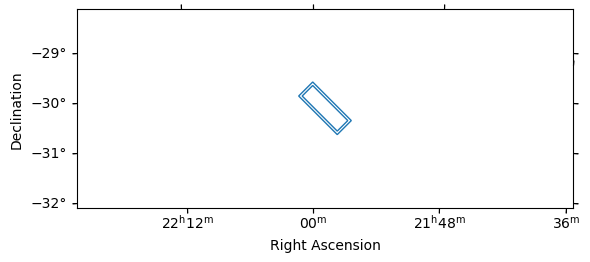

In [8]:
ax = Map.from_geom(geom=wcs_geom, data=True).plot()
complex_region_geom.plot_region(ax=ax)

Let's check that alignment is correct with respect to galactic frame.

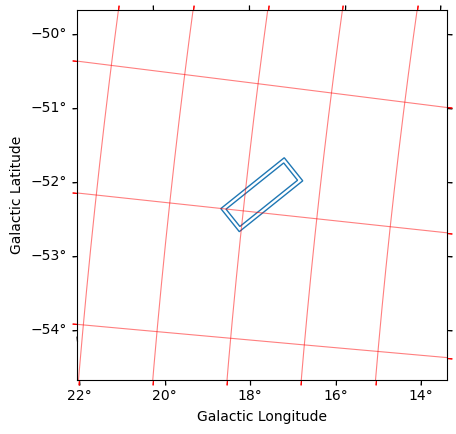

In [9]:
# We first create a galacitc Geom and plot an empty map
galactic_geom = WcsGeom.create(
    skydir=wcs_geom.center_skydir, 
    width=(5,5),
    frame="galactic")
ax = Map.from_geom(galactic_geom, data=True).plot()

# Let's overlay the ICRS coord grid

# We use astropy.visualization.WCSAxes.get_coord_overlay
overlay = ax.get_coords_overlay('icrs')

overlay['ra'].set_ticks(color='red')
overlay['dec'].set_ticks(color='red')

overlay.grid(color='red', linestyle='solid', alpha=0.5)

ax = complex_region_geom.plot_region(ax=ax)

### Non spatial axes: `MapAxis`

In [10]:
from gammapy.maps import TimeMapAxis, MapAxis, MapAxes, LabelMapAxis

energy_axis = MapAxis.from_bounds(0.1, 10, nbin=8, unit="TeV", name="energy", interp="log")
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 8         
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+01 TeV
	interp     : log       



All `MapAxes` have contiguous bins. Some additional axes can have non adjacent bins: the `TimeMapAxis` and the `LabelMapAxis`.

In [11]:
time_map_axis = TimeMapAxis(
    edges_min=[1, 5, 10, 15] * u.day,
    edges_max=[2, 7, 13, 18] * u.day,
    reference_time=Time("2020-03-19"),
)
print(time_map_axis)

TimeMapAxis
-----------

  name           : time      
  nbins          : 4         
  reference time : 2020-03-19 00:00:00.000
  scale          : utc       
  time min.      : 2020-03-20 00:00:00.000
  time max.      : 2020-04-06 00:00:00.000
  total time     : 216.0 h   



In [12]:
label_axis = LabelMapAxis(
    labels=["A", "B", "C"], name="event type"
)

print(label_axis)

LabelMapAxis
------------

  name       : event type
  nbins      : 3         
  node type  : label     
  labels     : [np.str_('A'), np.str_('B'), np.str_('C')]



In [13]:
axes= MapAxes([energy_axis, time_map_axis])

In [14]:
wcs_5D_geom = wcs_geom.to_cube(axes=axes)

wcs_map = Map.from_geom(geom=wcs_5D_geom)

print(wcs_map)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy', 'time']
	shape : (np.int64(250), np.int64(100), 8, 4)
	ndim  : 4
	unit  : 
	dtype : float32



#### Understanding Geom structure and data shape

The data shape stored in the Map always has the spatial dimensions on the right. Non spatial axes dimensions are in reverse order.

$$
\begin{array}{@{}lcl@{}}
\texttt{Geom structure} & \longleftrightarrow & \texttt{map.data.shape} \\[8pt]
\hline
\texttt{MapAxes(["energy", "time", "event type"])}        & \Rightarrow & (N_L, N_T, N_E) \\[6pt]
\texttt{WCS spatial (y, x)}                 & \Rightarrow & (N_Y, N_X) \\[10pt]
\hline
\textbf{Full Map data shape:} & & (N_L, N_T,\, N_E,\, N_Y,\, N_X)
\end{array}
$$

For a `RegionGeom` the spatial dimensions are kept:
$$
\begin{array}{@{}lcl@{}}
\texttt{Geom structure} & \longleftrightarrow & \texttt{map.data.shape} \\[8pt]
\hline
\texttt{MapAxes(["energy", "time", "event type"])}        & \Rightarrow & (N_L, N_T, N_E) \\[6pt]
\texttt{Region spatial (y, x)}                 & \Rightarrow & (1, 1) \\[10pt]
\hline
\textbf{Full Map data shape:} & & (N_L, N_T,\, N_E,\, 1,\, 1)
\end{array}
$$



In [15]:
print(wcs_map.data.shape)

(4, 8, 100, 250)


### Coordinate handling, indexing, slicing, interpolating

Accessing coordinates of every voxel in the Geom:

In [16]:
# Let's use a simpler geometry
wcs_3D_geom = wcs_geom.to_cube([energy_axis])
wcs_3D_map = Map.from_geom(wcs_3D_geom, data=True)

# We can use a sparse representation that allows broadcasting
coordinates = wcs_3D_geom.get_coord(sparse=True)

# MapCoord behaves like a dict
print(coordinates)

# With convenience methods to access e.g. SkyCoords
print(coordinates.skycoord.shape)

print(coordinates["energy"].shape)

MapCoord

	axes     : ['lon', 'lat', 'energy']
	shape    : (250, 100, 8)
	ndim     : 3
	frame : icrs

(1, 100, 250)
(8, 1, 1)


In [17]:
# Get all values at center position
coords = {"lon":329.7, "lat":-30.7, "energy":coordinates["energy"]}

wcs_3D_map.set_by_coord(coords, False)

print(wcs_3D_map.get_by_coord(coords))

[[[False]]

 [[False]]

 [[False]]

 [[False]]

 [[False]]

 [[False]]

 [[False]]

 [[False]]]


#### Slicing

To support slicing of non-spatial axes of Map objects, the Map object has a slice_by_idx() method, which allows to extract sub-maps from a larger map.

The following example demonstrates how to get the map at the energy bin number 3:

In [18]:
wcs_3D_map.slice_by_idx({"energy":3})

#### Interpolating

We can interpolate by `idx` or `coord`

In [19]:
wcs_3D_map.interp_by_coord({"skycoord": wcs_geom.center_skydir, "energy": [0.7, 11.2]*u.TeV})

array([1., 1.])

In [20]:
# interpolation over geometry, reprojection

## Data Structures

### From DL3 Files to a Gammapy Observation

**Concepts:**

- The DL3 format separates events, GTIs, and IRFs (AEFF, EDISP, PSF, BKG) as well as metadata.
- `Observation` provides a unified interface to these.
- `Observations` is a sequence of `Observation`

An `Observation` can be created directly in memory. But in general access to observations on disk is done through a `DataStore`. The index of observation files is provided by the `DataStore.hdu_index` table

When created from the `DataStore`, `Observation` acts as a lazy loader for its components, typically:
- `obs.events` (`EventList`)
- `obs.gti` (`GTI`)
- `obs.aeff`
- `obs.edisp`
- `obs.psf`
- `obs.bkg`

#### Loading an observation


In [21]:
from gammapy.data import DataStore

datastore = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
display(datastore.obs_table[:3])

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,deg,deg,deg,deg,deg,deg,deg,s,s,,s,s,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110380,267.68121338,-29.6075,359.9999912037958,-1.299995937905366,0.0,90.0,0,1800.0,1764.0,0.98000001907,664502400.0,664504192.0,2021-01-21,11:58:51,2021-01-21,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110380.fits,106217
111140,264.2315979,-29.5214,358.4999833830074,1.3000020211954284,0.0,90.0,0,1800.0,1764.0,0.98000001907,667958400.0,667960192.0,2021-03-02,11:58:51,2021-03-02,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_111140.fits,106386
111159,266.03671265,-26.9782,1.5000056568267741,1.299940468335294,0.0,90.0,0,1800.0,1764.0,0.98000001907,668044800.0,668046592.0,2021-03-03,11:58:51,2021-03-03,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_111159.fits,105741


In [22]:
obs = datastore.obs(110380)
print(obs)
print(obs.psf)

Observation

	obs id            : 110380 
 	tstart            : 59235.50
	tstop             : 59235.52
	duration          : 1800.00 s
	pointing (icrs)   : 267.7 deg, -29.6 deg

	deadtime fraction : 2.0%

EnergyDependentMultiGaussPSF
----------------------------

  axes      : ['energy_true', 'offset']
  shape     : (25, 6)
  ndim      : 2
  parameters: ['sigma_1', 'sigma_2', 'sigma_3', 'scale', 'ampl_2', 'ampl_3']



#### A note of caution about lazy loading 
Lazy loading is there to only perform IO when needed. If you don't use events, they won't be loaded into memory. 
Note that to avoid overloading memory with too many event lists or IRFs, they are not cached in memory. This means that two subsequent calls to `obs.events` will trigger a new file read.

In [23]:
# Impact of lazy loading without caching

events1 = obs.events
events2 = obs.events

print(events1 is events2)

False


This behaviour can cause I/O overhead if access to `Observation` components are too frequent. It is advised to work directly with the `events`.

As exercice, you can try to add a `'PHASE'` column on the `EventList.table` and see if is maintained. 

In [24]:
# Note that this behaviour can be changed at the class level.
# We show here how to do it, but we don't advise to change.
from gammapy.data import Observation
Observation._events.cache = True

obs = datastore.obs(111140)

events1 = obs.events
events2 = obs.events

print(events1 is events2)

# reverting for the following
Observation._events.cache = False

True


### IRFs
IRFs describe the telescope’s response to incoming gamma rays.
Each IRF is represented as a specialized class in gammapy.irf, wrapping a multidimensional map structure with physical units and metadata.

EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (42, 6)
  ndim  : 2
  unit  : m2
  dtype : >f4



<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Effective Area [$\\mathrm{m^{2}}$]'>

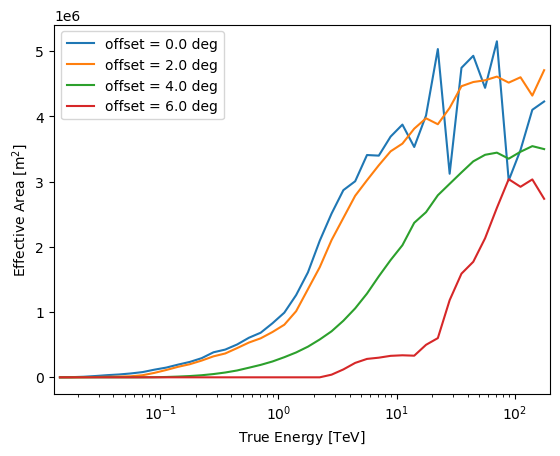

In [25]:
aeff = obs.aeff
print(aeff)
aeff.plot_energy_dependence()

IRFs support evaluation/interpolation over the required axes.

In [26]:
aeff.evaluate(energy_true=np.geomspace(0.05*u.TeV,100*u.TeV,100)[:,np.newaxis] , offset=np.linspace(0,3*u.deg)[np.newaxis,:])

<Quantity [[5.12437494e+04, 5.01232687e+04, 4.90027880e+04, ...,
            1.86952510e+03, 1.69017991e+03, 1.51083473e+03],
           [5.64716943e+04, 5.52327585e+04, 5.39938226e+04, ...,
            2.54234355e+03, 2.29947738e+03, 2.05661121e+03],
           [6.25448359e+04, 6.12289474e+04, 5.99130588e+04, ...,
            4.28540757e+03, 3.88195614e+03, 3.47850472e+03],
           ...,
           [3.37479267e+06, 3.43944835e+06, 3.50410402e+06, ...,
            3.84402355e+06, 3.80083677e+06, 3.75764999e+06],
           [3.09649797e+06, 3.17572130e+06, 3.25494463e+06, ...,
            3.79804058e+06, 3.76070549e+06, 3.72337041e+06],
           [3.25232276e+06, 3.32534928e+06, 3.39837580e+06, ...,
            3.89176573e+06, 3.86136871e+06, 3.83097169e+06]] m2>

#### Pointlike IRFs

Obs Id:   0%|          | 0/2 [00:00<?, ?it/s]

Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 5029747
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 5029748


Observations
Number of observations: 0



Obs Id:   0%|          | 0/2 [00:00<?, ?it/s]

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


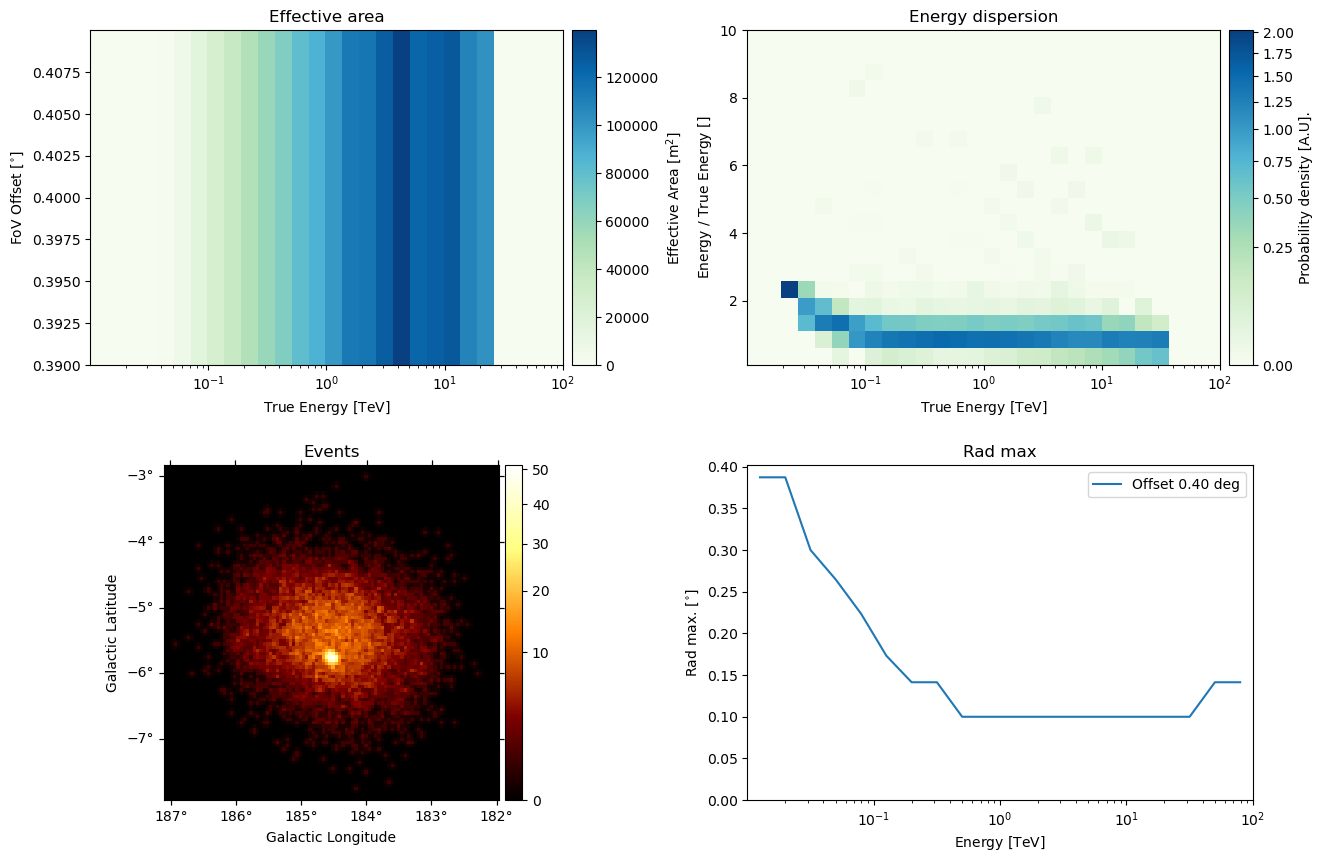

In [27]:
data_store_magic = DataStore.from_dir("$GAMMAPY_DATA/magic/rad_max/data")
observations = data_store_magic.get_observations()
print(observations)

observations = data_store_magic.get_observations(required_irf="point-like")

obs_magic = observations[0].peek()

#### Under the hood: the IRF abstraction

Each IRF is loaded as an array structure with labeled axes and unit support. It allows to perform interpolation over coordinates in the FoV system (e.g. `fov_lon` and `fov_lat` or `offset`).

One can create a new IRF class very simply. 

Exercice: create a 3D effective area object.

In [28]:
from gammapy.irf import IRF

# This is enough to create the class
class EffectiveArea3D(IRF):
    tag = "aeff_3d"
    required_axes = ["energy_true", "fov_lon", "fov_lat"]
    default_unit = u.m**2


#### From celestial to FoV coordinates

IRFs are defined in the FoV system of the instrument. Data reduction implies reprojecting on the user defined celestial geometry (i.e. `Map`).

In [29]:
from gammapy.utils.coordinates import FoVICRSFrame, FoVAltAzFrame
from astropy.coordinates import SkyCoord

coord = SkyCoord(5.63, 2.01, unit="deg", frame="galactic")
fov_frame = FoVICRSFrame(origin=obs.pointing.fixed_icrs)
fov_coord = coord.transform_to(fov_frame)
print(f"FoV_lon: {fov_coord.fov_lon}, FoV_lat: {fov_coord.fov_lat}")

FoV_lon: -3.2310120462279976 deg, FoV_lat: 6.395473880034677 deg


## Data reduction: DL3 to DL4, Makers

1. `point-like` irf :
 - only spectral (1D) analysis
 - region size fixed: use a `PointSkyRegion`, correction to be applied automatically from the `RadMax` values
 - usually no background model - background to be estimated using `WobbleRegionsFinder`
 - ON-OFF analysis - `wstat`
    
2. `full-enclosure` irf:

   - *spectral* (1D), `morphological` (2D) and 3D analysis possible
   - A `3D` analysis:
   - - `MapDataset` : Background estimated from a model
     - `MapDatasetOnOff`: Background estimated 
   - For a `1D` analysis:
   - -`SpectrumDatasetOnOff`: Background extracted from real 

In [30]:
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker, DatasetsMaker
import astropy.units as u

In [31]:
data_store_hess = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="228.32 deg",
    lat="-59.08 deg",
    radius="5 deg",
)
filtered = data_store_hess.obs_table.select_observations(selection)
observations = data_store_hess.get_observations(filtered["OBS_ID"])
obs = data_store_hess.obs(20136)

source_pos = SkyCoord(228.32, -59.08, unit="deg")
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 5, unit="TeV", per_decade=True)

geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.02,
    width=3.0,
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 10, unit="TeV", name="energy_true", per_decade=True
)

stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="stacked"
)

Obs Id:   0%|          | 0/20 [00:00<?, ?it/s]

An helper function exists to guess the shape of the MapDataset from the IRFs of the observation.

In [32]:
from gammapy.datasets import create_empty_map_dataset_from_irfs

empty_dataset = create_empty_map_dataset_from_irfs(obs, dataset_name="test-hess", spatial_bin_size=0.02*u.deg)

print(empty_dataset.counts.geom)

/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(275), np.int64(275), 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 228.6 deg, -58.8 deg
	width      : 5.5 deg x 5.5 deg
	wcs ref    : 228.6 deg, -58.8 deg



In [33]:
# by default create all quantities and IRFs
maker = MapDatasetMaker()

# Safe mask Maker is there to exclude regions of poor quality of IRFs
offset_max = 2.5 * u.deg

maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max=offset_max
)

<WCSAxes: >

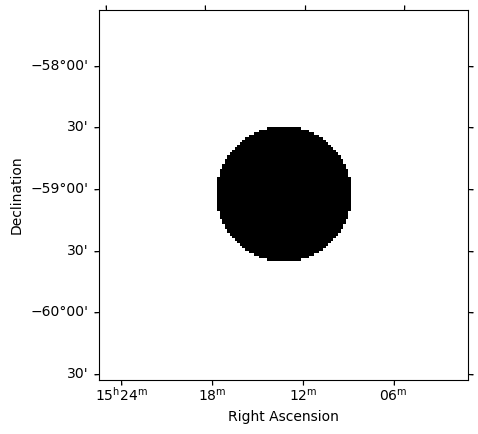

In [34]:
src_reg = CircleSkyRegion(center=source_pos, radius=0.55*u.deg)
exclusion_mask = geom.region_mask([src_reg], inside=False)
exclusion_mask.sum_over_axes().plot()

In [35]:
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [36]:
datasets_maker = DatasetsMaker([maker, maker_safe_mask, maker_fov], cutout_mode="partial", n_jobs=5, stack_datasets=False)

In [37]:
datasets = datasets_maker.run(empty_dataset, observations)

Data reduction:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
stacked_dataset = datasets.stack_reduce()

stacked_dataset.plot_residuals_spatial(vmin=-0.5, vmax=0.5)

### FoV modelling - does the background match in the source free region?

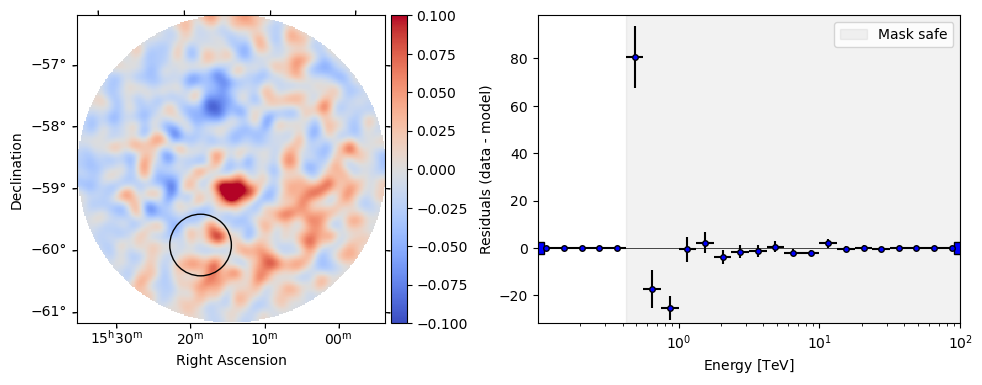

In [38]:
from regions import CircleSkyRegion
reg1 = CircleSkyRegion(center=SkyCoord(229.62, -60.01, unit="deg"), radius=0.5*u.deg)

rc_params = {"image.cmap": "RdBu_r", "lines.markerfacecolor": "blue", "lines.markersize": 8, "lines.marker": "s"}

with plt.rc_context(rc_params):
    datasets[0].plot_residuals(kwargs_spectral={"region":reg1}, kwargs_spatial={"vmin":-0.1, "vmax":0.1, "add_cbar": True})

The background model does not work very well both spectrally and spatially.

We can improve on this by passing corrective models to the `FoVBackgroundMaker`.

Let's introduce a piecewise spectral correction in the form of a `PieceWiseNormSpectralModel`. 

In [39]:
from gammapy.modeling.models import PiecewiseNormSpectralModel, GaussianPrior

piecewise_correction = PiecewiseNormSpectralModel(energy=[0.5,0.7, 1.1, 2.5, 8.0, 15]*u.TeV)

for par in piecewise_correction.parameters:
    par.prior = GaussianPrior(mu=1, sigma=0.15)


In [40]:
maker_safe_mask1 = SafeMaskMaker(methods=["aeff-max"])

In [41]:
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask, spectral_model= piecewise_correction)
datasets_maker = DatasetsMaker([maker, maker_safe_mask1, maker_fov], cutout_mode="partial", stack_datasets=False)

In [42]:
dataset = datasets_maker.run(empty_dataset, [obs])[0]

Data reduction:   0%|          | 0/1 [00:00<?, ?it/s]

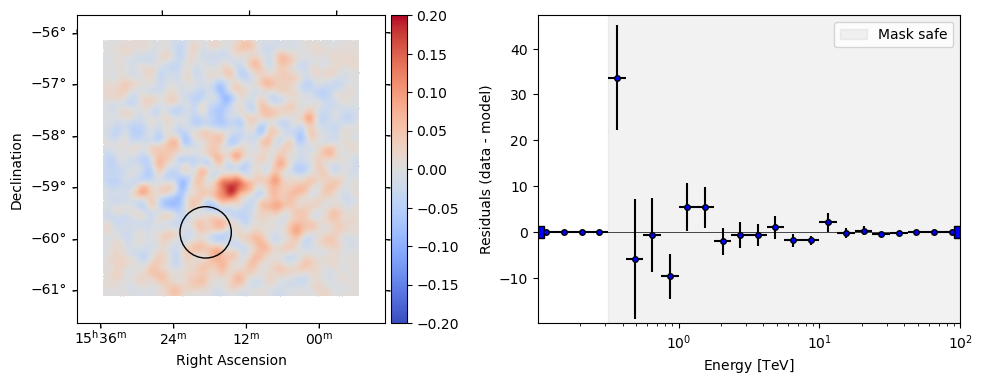

In [43]:
with plt.rc_context({"image.cmap": "RdBu_r", "lines.markerfacecolor": "blue", "lines.markersize": 8, "lines.marker": "s"}):
    dataset.plot_residuals(kwargs_spectral={"region":reg1}, kwargs_spatial={"vmin":-0.2, "vmax":0.2, "add_cbar": True})

In [44]:
dataset.background_model

### Experiment: trying to correct for spatial residuals in the runwise background

This is better, but the spatial background still has a strong gradient. 

We can try to correct it with a spatial correction. This is a tricky part.

For now we use a very generic piece wise spatial model. Simpler models with less parameters should be better suited...

Here we have to define a series of nodes that cover the FoV.

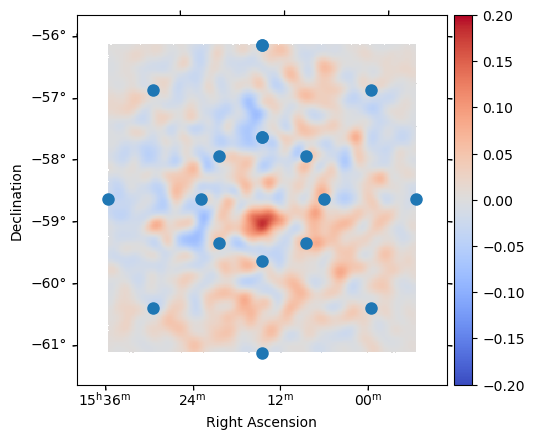

In [45]:
from gammapy.modeling.models import PiecewiseNormSpatialModel, PowerLawNormSpectralModel
from gammapy.maps import MapCoord

rotation = np.linspace(0, 360, 9)*u.deg
offset = [1., 2.5]*u.deg
R, O = np.meshgrid(rotation, offset)

geom = empty_dataset.counts.geom
coords = geom.center_skydir.directional_offset_by(R.flatten(), O.flatten())

with plt.rc_context({"image.cmap": "RdBu_r", "lines.markerfacecolor": "blue", "lines.markersize": 8, "lines.marker": "s"}):
    ax = dataset.plot_residuals_spatial(vmin=-0.2, vmax=0.2, add_cbar= True)
    ax.scatter(coords.ra, coords.dec, transform=ax.get_transform('world'))

In [46]:
coords= MapCoord({"lon":coords.ra, "lat":coords.dec}, frame="icrs")

gradient = PiecewiseNormSpatialModel(coords)

for par in gradient.parameters:
    par.prior = GaussianPrior(mu=1.0, sigma=0.1)

piecewise_correction = datasets[0].background_model.spectral_model.copy()
#piecewise_correction.freeze()

maker_fov = FoVBackgroundMaker(
    method="fit", 
    exclusion_mask=exclusion_mask, 
    spectral_model=piecewise_correction,
    spatial_model=gradient
)

datasets_maker = DatasetsMaker([maker, maker_safe_mask, maker_fov], cutout_mode="partial", stack_datasets=False)

In [47]:
dataset = datasets_maker.run(empty_dataset, [obs])[0]

Data reduction:   0%|          | 0/1 [00:00<?, ?it/s]

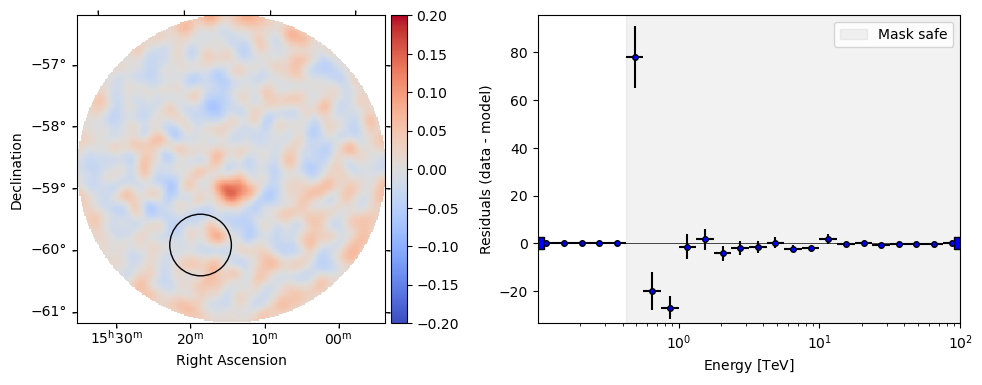

In [48]:
with plt.rc_context({"image.cmap": "RdBu_r", "lines.markerfacecolor": "blue", "lines.markersize": 8, "lines.marker": "s"}):
    dataset.plot_residuals(kwargs_spectral={"region":reg1}, kwargs_spatial={"vmin":-0.2, "vmax":0.2, "add_cbar": True})

<WCSAxes: >

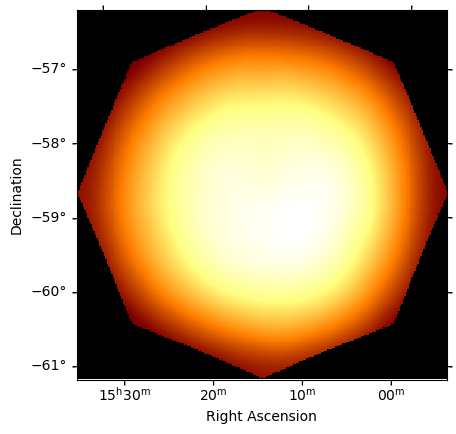

In [49]:
dataset.npred_background().sum_over_axes().plot()

<WCSAxes: >

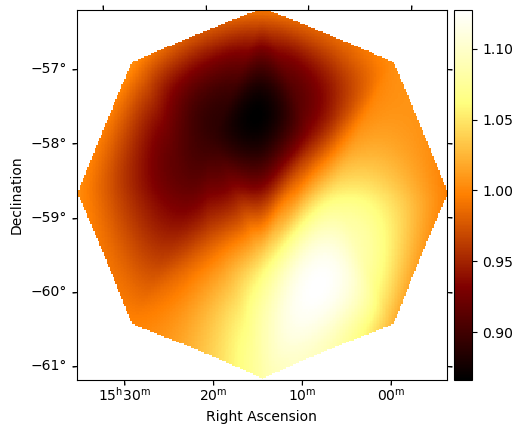

In [50]:
img_geom = dataset.counts.geom.to_image()
res = dataset.background_model.spatial_model.evaluate_geom(img_geom)
Map.from_geom(img_geom, data=res).plot(add_cbar=True)

**Exercise**: make our life easy and create a spatial correction model more adapted to a gradient effect

Now let's put everything together and make a full data reduction using this (quite complex) technique.

In [51]:
def get_piecewise_spectral_correction():
    piecewise_correction = PiecewiseNormSpectralModel(energy=[0.5,0.7, 1.1, 2.5, 8.0, 15]*u.TeV)

    for par in piecewise_correction.parameters:
        par.prior = GaussianPrior(mu=1, sigma=0.15)
    return piecewise_correction

def get_piecewise_spatial_correction(geom):
    rotation = np.linspace(0, 360, 9)*u.deg
    offset = [1., 2.5]*u.deg
    R, O = np.meshgrid(rotation, offset)

    geom = empty_dataset.counts.geom
    coords = geom.center_skydir.directional_offset_by(R.flatten(), O.flatten())

    coords= MapCoord({"lon":coords.ra, "lat":coords.dec}, frame="icrs")

    gradient = PiecewiseNormSpatialModel(coords)

    for par in gradient.parameters:
        par.prior = GaussianPrior(mu=1.0, sigma=0.1)
    return gradient

In [52]:
maker_safe_mask1 = SafeMaskMaker(methods=["aeff-max"])
maker_safe_mask2 = SafeMaskMaker(methods=["offset-max",], offset_max=2.3*u.deg)

In [53]:
stacked = empty_dataset.copy()
for obs in observations[:5]:
    cutout = empty_dataset.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * 3*u.deg, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)

    # The data quality cut is applied
    dataset = maker_safe_mask1.run(dataset, obs)
    
    # The resulting dataset cutout is stacked onto the final one
    maker_fov = FoVBackgroundMaker(
            method="fit", 
            exclusion_mask=exclusion_mask, 
            spectral_model=get_piecewise_spectral_correction(),
            spatial_model=get_piecewise_spatial_correction(dataset.counts.geom)
    )
    dataset = maker_fov.run(dataset)
    
    # The new data quality cut is applied
    dataset = maker_safe_mask2.run(dataset, obs)

    stacked.stack(dataset)

/Users/terrier/Code/mambaforge/envs/gammapy-2.0/lib/python3.12/site-packages/gammapy/utils/interpolation.py:207: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


<WCSAxes: >

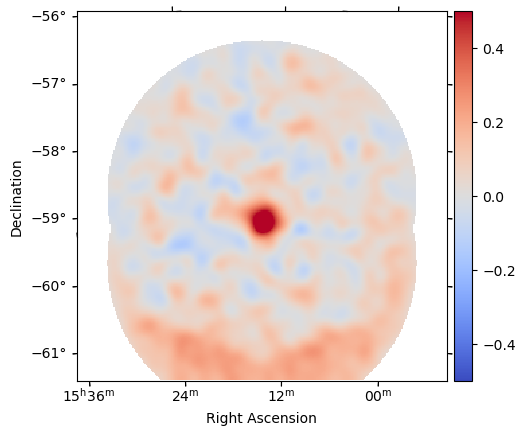

In [54]:
stacked.plot_residuals_spatial(vmin=-0.5, vmax=0.5)

So much for nothing, this is probably worse than without correction. We need a less complex spatial model.

Another option is to try to correct for non-uniformities at later steps on the stacked dataset.

In [55]:
stacked_dataset = datasets.stack_reduce()

<WCSAxes: >

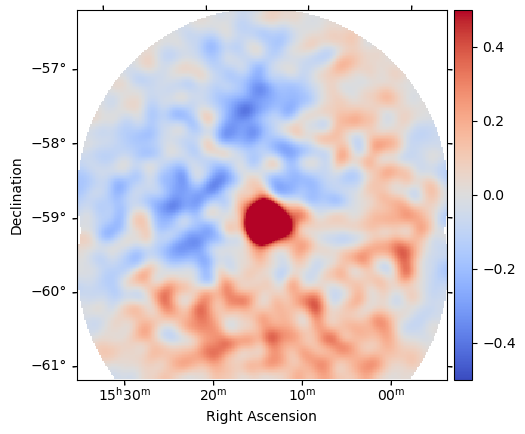

In [56]:
stacked_dataset.plot_residuals_spatial(vmin=-0.5, vmax=0.5)

## Models: Spectral, Spatial, and Temporal Components

In Gammapy v2.0, each astrophysical source is represented by a **`SkyModel`**.  
It combines three separable components:

$$\Phi(E_t, l, b, t) = \underbrace{\frac{dN}{dE_t}(E_t)}_{\rm cm^{-2}\ s^{-1}\ TeV^{-1}} \times \quad \underbrace{M(l,b)}_{\rm sr^{-1}}\quad \times \quad \underbrace{T(t)}_{\rm dimensionless}$$


Specifically:
| Component | Class | Meaning | Output Units |
|------------|--------|----------|--------------|
| **Spectral** | `SpectralModel` | Differential photon flux: $\frac{dN}{dE_t}$ | `ph / (cm2 s TeV)` |
| **Spatial**  | `SpatialModel`  | Spatial photon distribution $M(l,b)$, *normalized* | `1/sr` |
| **Temporal** | `TemporalModel` | Time modulation $T(t)$ | dimensionless |

The total model flux is the product:
\[
\Phi(E, l, b, t) = S(E)\,M(l,b)\,T(t)
\]
and this flux is *forward-folded* through exposure, PSF and energy dispersion
to compute expected counts per bin.Models
SkyModel and its substructure


In [57]:
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    ExpDecayTemporalModel,
)
import astropy.units as u
from astropy.time import Time

# --- Spectral component ---
spectral_model = PowerLawSpectralModel(
    amplitude=3e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2.3,
    reference=1 * u.TeV,
)

# --- Spatial component ---
spatial_model = PointSpatialModel(lon_0="0.5 deg", lat_0="-0.2 deg", frame="galactic")

# --- Temporal component ---
t_ref = Time("2000-01-01T00:00:00").mjd * u.d
temporal_model = ExpDecayTemporalModel(t_ref=t_ref, t0="1 yr")

# --- Combine into a SkyModel ---
sky_model = SkyModel(
    spectral_model=spectral_model,
    spatial_model=spatial_model,
    temporal_model=temporal_model,
    name="decaying-source",
    apply_irf={"exposure": True, "psf": True, "edisp": True},
)

print(sky_model)

SkyModel

  Name                      : decaying-source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : ExpDecayTemporalModel
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   3.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.500   +/-    0.00 deg         
    lat_0                         :     -0.200   +/-    0.00 deg         
    t0                            :      1.000   +/-    0.00 yr          
    t_ref                 (frozen):  51544.000       d           




#### SkyModels with 3D extended source templates - diffuse emissions

When complex diffuse models mix spatial and spectral dimensions (e.g. interstellar emissions), one uses a dimensionless spectral model $N(E_t)$ and a template 3D model $B(l,b,E_t)$:
$$\Phi(E_t, l, b, t) = \underbrace{S(E_t)}_{\rm dimensionless} \times \quad \underbrace{B(l,b,E_t)}_{\rm ph\,cm^{-2}\,s^{-1}\,sr^{-1}} $$



In [58]:
from gammapy.modeling.models import TemplateSpatialModel


## Forward Folding: computing NPred with the MapEvaluator

The predicted counts map $N_{\text{pred}}$ is computed by folding the model through
the instrument response:
$$
N_{\text{pred}}(E,l,b)
= \int \Phi(E_t, l_l, b_t, t) \times
  R(E,l,b\mid E_t,l_t,b_t,t)\, dE_t\,dl_t\,db_t\,dt
$$
where $R$ includes exposure, PSF and energy dispersion.

This integral is performed by the `~gammapy.datasets.evaluator.MapEvaluator`.

In [59]:
from gammapy.datasets import MapDataset
ds = MapDataset.read("/Users/terrier/Code/gammapy-dev/gammapy-data/cta-1dc-gc/cta-1dc-gc.fits.gz")

In [60]:
print(ds.evaluators)

{}


In [61]:
ds.models = sky_model

In [62]:
print(ds.evaluators)

{'decaying-source': <gammapy.datasets.evaluator.MapEvaluator object at 0x16a6e5be0>}


In [63]:
npred = ds.npred_signal('decaying-source')

Convolution:   0%|          | 0/14 [00:00<?, ?it/s]

In [64]:
npred.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [65]:
# We compute the true flux distribution
flux = ds.evaluators["decaying-source"].compute_flux()
print(flux)
# Then multiply by exposure
counts_noIRFs = ds.evaluators["decaying-source"].apply_exposure(flux)
# Convolve by PSF
counts_afterPSF = ds.evaluators["decaying-source"].apply_psf(counts_noIRFs)
# Convolve by Edisp
npred = ds.evaluators["decaying-source"].apply_edisp(counts_afterPSF)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (np.int64(37), np.int64(37), 14)
	ndim  : 3
	unit  : yr / (d s cm2)
	dtype : float64



Convolution:   0%|          | 0/14 [00:00<?, ?it/s]

In [66]:
print(npred)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (np.int64(37), np.int64(37), 10)
	ndim  : 3
	unit  : 
	dtype : float32



#### Fit and parameter estimation

Let's have a look at the parameter constraint tutorial.

## Estimators: from DL4 to DL5

The core of any estimator algorithm is **hypothesis testing**: a reference model or counts excess is tested against a null hypothesis. From the best fit reference model a flux is derived and a corresponding 
 value from the difference in fit statistics to the null hypothesis. 

In general the flux can be estimated using two methods:

### Forward folding (using model fitting)

Given a (global) best fit model with multiple model components, the flux of the component of interest is re-fitted in the chosen energy, time or spatial region. The new flux is given as a norm with respect to the global reference model. Optionally the free parameters of the other models can be re-optimised (but the other parameters of the source of interest are always kept frozen). 

### Backward folding (using excess): 

One can estimate the significance of the presence of signal counts beyond the expected background (for instance based on Li & Ma (1983). In this case the “best fit” flux and significance are given by the excess over the null hypothesis. This method is currently only exposed in the ExcessMapEstimator

Assuming one degree of freedom, $\sqrt{\Delta TS}$ represents an approximation (Wilk’s theorem) of the “classical significance”. In case of a negative best fit flux, e.g. when the background is overestimated, the significance is defined as $-\sqrt{\Delta\,TS}$ by convention.


### Flux estimators

Most estimators produce flux estimates.

They run on bins of **reconstructed energy**. 

- The estimator does not modify the binning of the parent dataset, only group the energy bins.
- The requested edges are used to group the parent dataset energy edges into large bins.
- Therefore, the input energy edges are not always the same as the output energy bins provided in the final product.

In each bin, the estimator will determine the flux normalization factor, by performing a fit comparing predicted number of counts in the reference model to observed ones. Hence, the flux value in bin $i$ is:

$$ \Phi_i = k_i\, \Phi_{ref}(E_i)$$

